## HW2
- Create your own GitHub repository for homework GITHUB_ID/PHBS_TQFML (make sure to make it public)
- Write a Jupyter notebook GITHUB_ID/PHBS_TQFML/HW/bank_marketing.ipynb:
- load data (bank.csv, smaller sample), normalize, and devide training/test sets
- randomly select 2 or 3 features
- apply the methods covered in Ch. 3 with SK-learn (logistic regress, SVM, decision tree, etc)
- check the accuracy and plot the outcome
- repeat above to find better feature
- commit the best result and don't foget to sync to the repository

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

- plot_decision_regions function from PML Ch03

In [2]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

- Import data
- Encode catagories
- Normalize
- Split data into training set and test set

In [3]:
dataset = pd.read_csv('bank.csv', sep = ';', header=0)
d = {
    'yes' : 1,
    'no' : 0
}
dataset['default'] = dataset['default'].map(d)
dataset['housing'] = dataset['housing'].map(d)
dataset['loan'] = dataset['loan'].map(d)
dataset['y'] = dataset['y'].map(d)

edus = pd.get_dummies(dataset['education'])
jobs = pd.get_dummies(dataset['job'])
maritals = pd.get_dummies(dataset['marital'])
contacts = pd.get_dummies(dataset['contact'])
months = pd.get_dummies(dataset['month'])
poutcomes = pd.get_dummies(dataset['poutcome'])

u = edus.pop('unknown')
u = jobs.pop('unknown')
u = contacts.pop('unknown')
u = poutcomes.pop('unknown')

dataset = dataset.join(edus)
dataset = dataset.join(jobs)
dataset = dataset.join(maritals)
dataset = dataset.join(contacts)
dataset = dataset.join(months)
dataset = dataset.join(poutcomes)

u = dataset.pop('job')
u = dataset.pop('marital')
u = dataset.pop('education')
u = dataset.pop('contact')
u = dataset.pop('month')
u = dataset.pop('poutcome')

y = dataset.pop('y')

column_names = dataset.columns.values.tolist()

df = dataset.values
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df)
df = pd.DataFrame(df_scaled)

c = dict(zip(range(dataset.columns.size),column_names))

df = df.rename(mapper = c, axis = 'columns')

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=2333, stratify=y)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


### Perceptron
- Select two best features (maximize accuracy score)

In [4]:
from sklearn.linear_model import Perceptron

def find_best_features(X_train, X_test, y_train, y_test):
    best_score = 0
    column_names = X_train.columns.values.tolist()
    c = dict(zip(range(X_train.columns.size),column_names))
    for ii in range(X_train.columns.size):
        for jj in range(X_train.columns.size):
            if jj > ii:
                ppn = Perceptron(max_iter=100, eta0=0.1, random_state=2333)
                ppn.fit(X_train[[c[ii],c[jj]]], y_train)
                y_pred = ppn.predict(X_test[[c[ii],c[jj]]])
                score = accuracy_score(y_test, y_pred)
                if score > best_score:
                    best_score = score
                    best_features = [c[ii],c[jj]]
                    idx1 = ii
                    idx2 = jj
    return [best_features, [idx1, idx2], best_score]

In [5]:
output = find_best_features(X_train, X_test, y_train, y_test)
print(output)

[['duration', 'blue-collar'], [6, 14], 0.8975681650700074]


- Plot the outcome (using the output of find_best_features)

In [6]:
def plot_best_feature(output, X_train, X_test, y_train, y_test):
    ppn = Perceptron(max_iter=100, eta0=0.1, random_state=2333)
    ppn.fit(X_train[output[0]], y_train)
    
    X_combined = np.vstack((X_train[output[0]], X_test[output[0]]))
    y_combined = np.hstack((y_train, y_test))
    
    plot_decision_regions(X=X_combined, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
    plt.xlabel(output[0][0])
    plt.ylabel(output[0][1])
    plt.legend(loc='upper left')

    plt.tight_layout()
    #plt.savefig('images/ppn.png', dpi=300)
    plt.show()

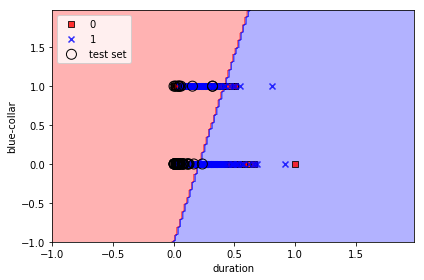

In [7]:
plot_best_feature(output, X_train, X_test, y_train, y_test)

### Logistic Regression
- Select two best features (maximize accuracy score)

In [8]:
from sklearn.linear_model import LogisticRegression

def find_best_features(X_train, X_test, y_train, y_test):
    best_score = 0
    column_names = X_train.columns.values.tolist()
    c = dict(zip(range(X_train.columns.size),column_names))
    for ii in range(X_train.columns.size):
        for jj in range(X_train.columns.size):
            if jj > ii:
                lr = LogisticRegression(C=100, random_state=2333)
                lr.fit(X_train[[c[ii],c[jj]]], y_train)
                y_pred = lr.predict(X_test[[c[ii],c[jj]]])
                score = accuracy_score(y_test, y_pred)
                if score > best_score:
                    best_score = score
                    best_features = [c[ii],c[jj]]
                    idx1 = ii
                    idx2 = jj
    return [best_features, [idx1, idx2], best_score]

In [9]:
output = find_best_features(X_train, X_test, y_train, y_test)
print(output)

[['duration', 'success'], [6, 43], 0.9012527634487841]


- Plot the outcome

In [10]:
def plot_best_feature(output, X_train, X_test, y_train, y_test):
    lr = LogisticRegression(C=100, random_state=2333)
    lr.fit(X_train[output[0]], y_train)
    
    X_combined = np.vstack((X_train[output[0]], X_test[output[0]]))
    y_combined = np.hstack((y_train, y_test))
    
    plot_decision_regions(X=X_combined, y=y_combined,
                      classifier=lr, test_idx=range(105, 150))
    plt.xlabel(output[0][0])
    plt.ylabel(output[0][1])
    plt.legend(loc='upper left')

    plt.tight_layout()
    #plt.savefig('images/ppn.png', dpi=300)
    plt.show()

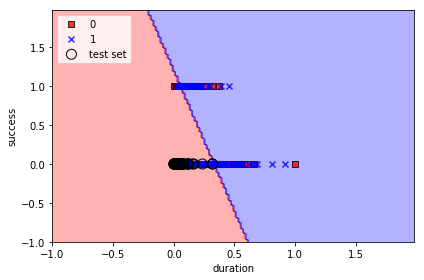

In [11]:
plot_best_feature(output, X_train, X_test, y_train, y_test)

### SVM (kernal: linear)
- Select two best features (maximize accuracy score)

In [12]:
from sklearn.svm import SVC

def find_best_features(X_train, X_test, y_train, y_test):
    best_score = 0
    column_names = X_train.columns.values.tolist()
    c = dict(zip(range(X_train.columns.size),column_names))
    for ii in range(X_train.columns.size):
        for jj in range(X_train.columns.size):
            if jj > ii:
                svm = SVC(kernel='linear', C=5.0, random_state=2333)
                svm.fit(X_train[[c[ii],c[jj]]], y_train)
                y_pred = svm.predict(X_test[[c[ii],c[jj]]])
                score = accuracy_score(y_test, y_pred)
                if score > best_score:
                    best_score = score
                    best_features = [c[ii],c[jj]]
                    idx1 = ii
                    idx2 = jj
    return [best_features, [idx1, idx2], best_score]

In [13]:
output = find_best_features(X_train, X_test, y_train, y_test)
print(output)

[['age', 'success'], [0, 43], 0.894620486366986]


- Plot the outcome

In [14]:
def plot_best_feature(output, X_train, X_test, y_train, y_test):
    svm = SVC(kernel='linear', C=5.0, random_state=2333)
    svm.fit(X_train[output[0]], y_train)
    
    X_combined = np.vstack((X_train[output[0]], X_test[output[0]]))
    y_combined = np.hstack((y_train, y_test))
    
    plot_decision_regions(X=X_combined, y=y_combined,
                      classifier=svm, test_idx=range(105, 150))
    plt.xlabel(output[0][0])
    plt.ylabel(output[0][1])
    plt.legend(loc='upper left')

    plt.tight_layout()
    #plt.savefig('images/ppn.png', dpi=300)
    plt.show()

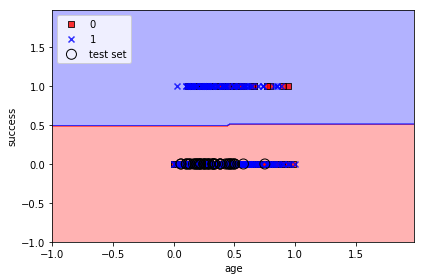

In [15]:
plot_best_feature(output, X_train, X_test, y_train, y_test)

### SVM (kernal: rbf)
- Select two best features (maximize accuracy score)

In [16]:
from sklearn.svm import SVC

def find_best_features(X_train, X_test, y_train, y_test):
    best_score = 0
    column_names = X_train.columns.values.tolist()
    c = dict(zip(range(X_train.columns.size),column_names))
    for ii in range(X_train.columns.size):
        for jj in range(X_train.columns.size):
            if jj > ii:
                svm = SVC(kernel='rbf', random_state=2333, gamma=0.10, C=10.0)
                svm.fit(X_train[[c[ii],c[jj]]], y_train)
                y_pred = svm.predict(X_test[[c[ii],c[jj]]])
                score = accuracy_score(y_test, y_pred)
                if score > best_score:
                    best_score = score
                    best_features = [c[ii],c[jj]]
                    idx1 = ii
                    idx2 = jj
    return [best_features, [idx1, idx2], best_score]

In [17]:
output = find_best_features(X_train, X_test, y_train, y_test)
print(output)

[['age', 'success'], [0, 43], 0.894620486366986]


- Plot the outcome

In [18]:
def plot_best_feature(output, X_train, X_test, y_train, y_test):
    svm = SVC(kernel='rbf', random_state=2333, gamma=0.10, C=10.0)
    svm.fit(X_train[output[0]], y_train)
    
    X_combined = np.vstack((X_train[output[0]], X_test[output[0]]))
    y_combined = np.hstack((y_train, y_test))
    
    plot_decision_regions(X=X_combined, y=y_combined,
                      classifier=svm, test_idx=range(105, 150))
    plt.xlabel(output[0][0])
    plt.ylabel(output[0][1])
    plt.legend(loc='upper left')

    plt.tight_layout()
    #plt.savefig('images/ppn.png', dpi=300)
    plt.show()

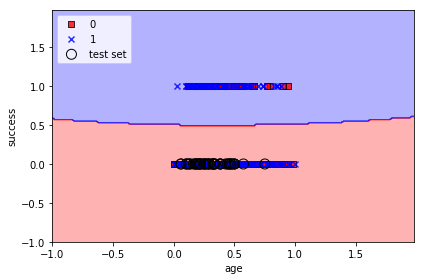

In [19]:
plot_best_feature(output, X_train, X_test, y_train, y_test)

### Decision Tree
- Select two best features (maximize accuracy score)

In [20]:
from sklearn.tree import DecisionTreeClassifier

def find_best_features(X_train, X_test, y_train, y_test):
    best_score = 0
    column_names = X_train.columns.values.tolist()
    c = dict(zip(range(X_train.columns.size),column_names))
    for ii in range(X_train.columns.size):
        for jj in range(X_train.columns.size):
            if jj > ii:
                tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=4, 
                              random_state=2333)
                tree.fit(X_train[[c[ii],c[jj]]], y_train)
                y_pred = tree.predict(X_test[[c[ii],c[jj]]])
                score = accuracy_score(y_test, y_pred)
                if score > best_score:
                    best_score = score
                    best_features = [c[ii],c[jj]]
                    idx1 = ii
                    idx2 = jj
    return [best_features, [idx1, idx2], best_score]

In [21]:
output = find_best_features(X_train, X_test, y_train, y_test)
print(output)

[['duration', 'success'], [6, 43], 0.9012527634487841]


- Plot the outcome

In [22]:
def plot_best_feature(output, X_train, X_test, y_train, y_test):
    tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=4, 
                              random_state=2333)
    tree.fit(X_train[output[0]], y_train)
    
    X_combined = np.vstack((X_train[output[0]], X_test[output[0]]))
    y_combined = np.hstack((y_train, y_test))
    
    plot_decision_regions(X=X_combined, y=y_combined,
                      classifier=tree, test_idx=range(105, 150))
    plt.xlabel(output[0][0])
    plt.ylabel(output[0][1])
    plt.legend(loc='upper left')

    plt.tight_layout()
    #plt.savefig('images/ppn.png', dpi=300)
    plt.show()

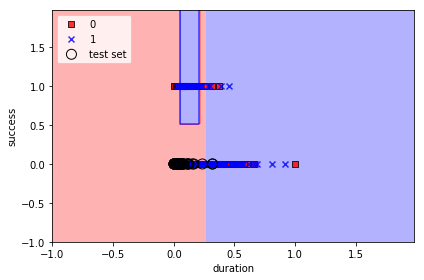

In [23]:
plot_best_feature(output, X_train, X_test, y_train, y_test)

### Random Forest
- Select two best features (maximize accuracy score)

In [33]:
from sklearn.ensemble import RandomForestClassifier

def find_best_features(X_train, X_test, y_train, y_test):
    best_score = 0
    column_names = X_train.columns.values.tolist()
    c = dict(zip(range(X_train.columns.size),column_names))
    for ii in range(X_train.columns.size):
        for jj in range(X_train.columns.size):
            if jj > ii:
                forest = RandomForestClassifier(criterion='gini',
                                n_estimators=10, 
                                random_state=2333,
                                n_jobs=2)
                forest.fit(X_train[[c[ii],c[jj]]], y_train)
                y_pred = forest.predict(X_test[[c[ii],c[jj]]])
                score = accuracy_score(y_test, y_pred)
                if score > best_score:
                    best_score = score
                    best_features = [c[ii],c[jj]]
                    idx1 = ii
                    idx2 = jj
    return [best_features, [idx1, idx2], best_score]

In [34]:
output = find_best_features(X_train, X_test, y_train, y_test)
print(output)

[['may', 'success'], [37, 43], 0.8960943257184967]


- Plot the outcome

In [35]:
def plot_best_feature(output, X_train, X_test, y_train, y_test):
    forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
    forest.fit(X_train[output[0]], y_train)
    
    X_combined = np.vstack((X_train[output[0]], X_test[output[0]]))
    y_combined = np.hstack((y_train, y_test))
    
    plot_decision_regions(X=X_combined, y=y_combined,
                      classifier=forest, test_idx=range(105, 150))
    plt.xlabel(output[0][0])
    plt.ylabel(output[0][1])
    plt.legend(loc='upper left')

    plt.tight_layout()
    #plt.savefig('images/ppn.png', dpi=300)
    plt.show()

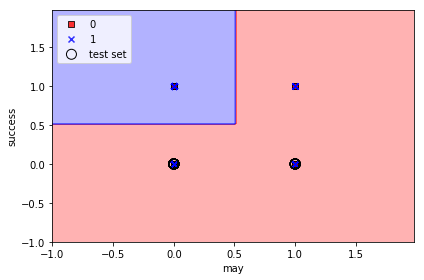

In [36]:
plot_best_feature(output, X_train, X_test, y_train, y_test)

### K-nearest neighbors (KNN)
- Select two best features (maximize accuracy score)

In [37]:
from sklearn.neighbors import KNeighborsClassifier

def find_best_features(X_train, X_test, y_train, y_test):
    best_score = 0
    column_names = X_train.columns.values.tolist()
    c = dict(zip(range(X_train.columns.size),column_names))
    for ii in range(X_train.columns.size):
        for jj in range(X_train.columns.size):
            if jj > ii:
                knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')
                knn.fit(X_train[[c[ii],c[jj]]], y_train)
                y_pred = knn.predict(X_test[[c[ii],c[jj]]])
                score = accuracy_score(y_test, y_pred)
                if score > best_score:
                    best_score = score
                    best_features = [c[ii],c[jj]]
                    idx1 = ii
                    idx2 = jj
    return [best_features, [idx1, idx2], best_score]

In [38]:
output = find_best_features(X_train, X_test, y_train, y_test)
print(output)

[['primary', 'success'], [10, 43], 0.8953574060427414]


- Plot the outcome

In [39]:
def plot_best_feature(output, X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')
    knn.fit(X_train[output[0]], y_train)
    
    X_combined = np.vstack((X_train[output[0]], X_test[output[0]]))
    y_combined = np.hstack((y_train, y_test))
    
    plot_decision_regions(X=X_combined, y=y_combined,
                      classifier=knn, test_idx=range(105, 150))
    plt.xlabel(output[0][0])
    plt.ylabel(output[0][1])
    plt.legend(loc='upper left')

    plt.tight_layout()
    #plt.savefig('images/ppn.png', dpi=300)
    plt.show()

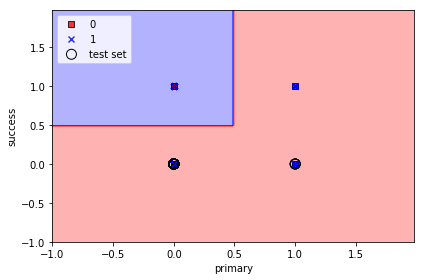

In [40]:
plot_best_feature(output, X_train, X_test, y_train, y_test)

## Conclusion

### The best features and their accuracy scores under each method are:

- Perceptron : 'duration'& 'blue-collar', accuracy score: 0.8975681650700074
- Logistic Regression : 'duration'& 'success', accuracy score: 0.9012527634487841
- SVM (kernal: linear) : 'age'& 'success', accuracy score: 0.894620486366986
- SVM (kernal: rbf) : 'age'& 'success', accuracy score: 0.894620486366986
- Decision Tree: 'duration'& 'success', accuracy score: 0.9012527634487841
- Random Forest: 'may'& 'success', accuracy score: 0.8960943257184967
- KNN: 'primary'& 'success', accuracy score: 0.8953574060427414

### Logistic Regression and Decision Tree both have the highest accuracy score 0.9012527634487841 under the bank.csv dataset. The best features they choose are 'duration' (last contact duration) and 'success' (the success of the previous marketing campaign)